# Foreign Voters and Kommunale Elections

Non-Danish citizens can vote in a few elections here. Foreign citizens and foreigners who have lived in Denmark for more than four years permanently can vote in regional and local elections.

How significant is this proportion of voters?

Statbank came up trumps and I now have the numbers of EU and long term residents who are eligible to vote vs the number of Danish voters


So let's have a look...

In [1]:
#Importing mah libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib.patches import Wedge
import squarify  
import textwrap  


In [2]:
#  Local Election Data, got this from KVRES on statbank (I really love statbank, did I tell you that today?)
df_stemmer = pd.read_csv('kommunalvalg.csv',encoding='utf-8', header=None)
df_stemmer.columns=['Party','Location','Votes']
#df_stemmer.head()

In [3]:
# Pivoting the table so you can inspect per kommune
df_pivot = df_stemmer.pivot_table(index='Location', columns='Party', values='Votes', aggfunc='sum').reset_index()
# Reorder columns after pivoting
columns = ['Location', 'GYLDIGE STEMMER I ALT'] + [col for col in df_pivot.columns if col not in ['Location', 'GYLDIGE STEMMER I ALT']]
df_pivot = df_pivot[columns]
df_pivot.columns.name = None  # Remove the name of columns index
#df_pivot.head() #debugging step

In [4]:
# Figure out what party got as a percentage of the valid votes cast in the 2021 local elections

total_votes_col = 'GYLDIGE STEMMER I ALT'
party_columns = [col for col in df_pivot.columns if col not in ['Location', total_votes_col]]

# Insert a percentage column after each party column
for party in party_columns:
    percent_col = f"{party} %"
    df_pivot[percent_col] = (df_pivot[party] / df_pivot[total_votes_col] * 100).round(1)

# Rearrange columns to place the percentage column right after each party's votes
new_column_order = ['Location', total_votes_col]
for party in party_columns:
    new_column_order.extend([party, f"{party} %"])

# Reorder the DataFrame columns
df_pivot = df_pivot[new_column_order]


In [5]:
#Here is where we can keep the elections data
df_elections = df_pivot
#df_elections.head()

In [6]:
# Now let's look at the numbers of Foreign and Danish citizens in the kommuner
df_voters = pd.read_csv('all_voters.csv',encoding='utf-8', header=None, sep=';')
df_voters.columns=['Location','Danish','Foreign']


In [7]:
# Calculate the total voters 
df_voters['Total'] = df_voters['Danish'] + df_voters['Foreign']

# Calculate the percentage columns and round to 1 decimal place
df_voters['Percentage Danish'] = (df_voters['Danish'] / df_voters['Total'] * 100).round(1)
df_voters['Percentage Foreign'] = (df_voters['Foreign'] / df_voters['Total'] * 100).round(1)

In [8]:
# Sort the DataFrame by the percentage of Danish adults column
df_voters = df_voters.sort_values(by='Percentage Danish').reset_index(drop=True)

In [9]:
# Sort kommunes by Percentage Foreign
kommunes = df_voters.sort_values(by='Percentage Foreign', ascending=False).head(98)

# Merge kommunes with the kommunalvalg data based on the kommune name
merged_df = pd.merge(kommunes, df_elections, on='Location', how='inner')

In [10]:
# Load the GeoJSON file with kommune boundaries
gdf_kommuner = gpd.read_file('kommuner.geojson')

# Merge the GeoDataFrame with df_voters on 'komnavn' in the GeoDataFrame and 'Location' in df_voters
gdf_merged = gdf_kommuner.merge(df_voters[['Location', 'Percentage Foreign']], left_on='KOMNAVN', right_on='Location', how='left')


Well done for making it this far, the data is cleaned and shaped and we are ready for the good bit. 
What is the ratio of Foreign to Danish adults in Denmark's kommuner?

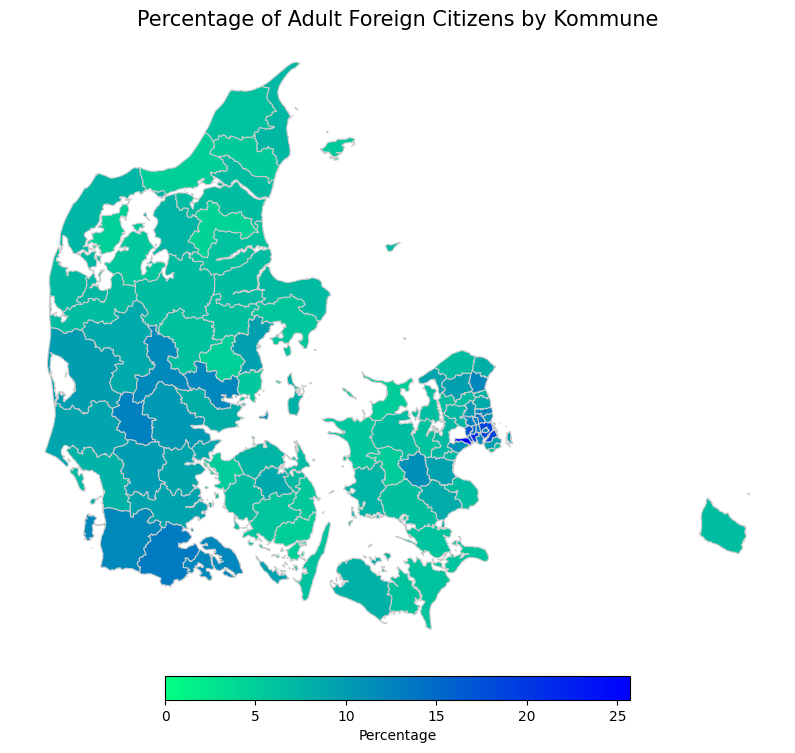

In [21]:
# Let's look at the data plotted on a map
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
gdf_merged.plot(
    column='Percentage Foreign',
    cmap='winter_r',  
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    vmin=0,          
    #vmax=20,         
    legend_kwds={
        'label': "Percentage",
        'orientation': "horizontal",
        'shrink': 0.6,  
        'pad': 0.02,    
    }
)

# Customize the plot
ax.set_title('Percentage of Adult Foreign Citizens by Kommune', fontsize=15)
ax.axis('off') 

plt.show()


It's not all CPH, is it?! There are high percentages of Foreign citizens all over Denmark. 
Ok, so the next bit is about seeing where the voting percentage of Foreign citizens would place in the 2021 local election cycle.
It's obviously a flawed measure because
1) Some of these people actually voted in that election and so they are being double counted
2) It is not 2021 anymore
3) We're looking at a group that traditionally don't vote in high numbers and comparing to 2021's total vote count rather than 2021's eligible count

But we're doing it anyway and just need to breathe the anxiety away that it is not the perfect way of measuring the effect

In [12]:
# List to store each kommune's ordered DataFrame
kommune_dfs = []

# Loop over each row in merged_df (each row represents a kommune)
for idx, row in merged_df.iterrows():
    kommune_name = row['Location']
    total_votes = row['GYLDIGE STEMMER I ALT']
    Foreign_votes = row['Foreign']
    Foreign_percentage = (Foreign_votes / total_votes) * 100
    
    # Create a DataFrame for the current kommune's parties and percentages
    kommune_data = pd.DataFrame({
        'Party': [col for col in merged_df.columns if ' %' in col],
        'Votes': [row[col.replace(' %', '')] for col in merged_df.columns if ' %' in col],
        'Vote Percentage': [row[col] for col in merged_df.columns if ' %' in col]
    })
    
    # Drop parties with zero votes
    kommune_data = kommune_data[kommune_data['Votes'] > 0]
    
    # Add the "Foreign Party" row
    Foreign_row = pd.DataFrame({
        'Party': ['Foreign Voters'],
        'Votes': [Foreign_votes],
        'Vote Percentage': [Foreign_percentage]
    })
    kommune_data = pd.concat([kommune_data, Foreign_row], ignore_index=True)
    
    # Sort by Vote Percentage in descending order
    kommune_data = kommune_data.sort_values(by='Vote Percentage', ascending=False).reset_index(drop=True)
    
    # Add the kommune name for context
    kommune_data['Kommune'] = kommune_name
    
    # Append to the list
    kommune_dfs.append(kommune_data)

In [13]:
# once:
kommune_by_name = {df['Kommune'].iat[0]: df for df in kommune_dfs}

# get København:
københavn_df = kommune_by_name['København']         
print(københavn_df.head(10))


                                   Party   Votes  Vote Percentage    Kommune
0                         Foreign Voters  101653        33.091246  København
1                         Enhedslisten %   75698        24.600000  København
2                 A. Socialdemokratiet %   52874        17.200000  København
3       C. Det Konservative Folkeparti %   40172        13.100000  København
4                  B. Radikale Venstre %   36688        11.900000  København
5      F. SF - Socialistisk Folkeparti %   33824        11.000000  København
6  V. Venstre, Danmarks Liberale Parti %   23578         7.700000  København
7                         Alternativet %    8988         2.900000  København
8                  I. Liberal Alliance %    8428         2.700000  København
9                    D. Nye Borgerlige %    6455         2.100000  København


In [14]:
# get Aarhus:
aarhus_df = kommune_by_name['Aarhus']         
print(aarhus_df.head(10))


                                   Party  Votes  Vote Percentage Kommune
0                 A. Socialdemokratiet %  55295        28.700000  Aarhus
1                         Foreign Voters  28988        15.066293  Aarhus
2       C. Det Konservative Folkeparti %  28077        14.600000  Aarhus
3      F. SF - Socialistisk Folkeparti %  26439        13.700000  Aarhus
4  V. Venstre, Danmarks Liberale Parti %  22835        11.900000  Aarhus
5                         Enhedslisten %  19044         9.900000  Aarhus
6                  B. Radikale Venstre %  17761         9.200000  Aarhus
7                    D. Nye Borgerlige %   6174         3.200000  Aarhus
8                  O. Dansk Folkeparti %   5252         2.700000  Aarhus
9                  I. Liberal Alliance %   3496         1.800000  Aarhus


In [15]:
# get Aalborg:
aalborg_df = kommune_by_name['Aalborg']         
print(aalborg_df.head(10))


                                   Party  Votes  Vote Percentage  Kommune
0                 A. Socialdemokratiet %  42149        36.900000  Aalborg
1  V. Venstre, Danmarks Liberale Parti %  21470        18.800000  Aalborg
2       C. Det Konservative Folkeparti %  12709        11.100000  Aalborg
3                         Foreign Voters  12304        10.766161  Aalborg
4                         Enhedslisten %   9428         8.200000  Aalborg
5                  B. Radikale Venstre %   8055         7.000000  Aalborg
6      F. SF - Socialistisk Folkeparti %   6353         5.600000  Aalborg
7                  O. Dansk Folkeparti %   4683         4.100000  Aalborg
8                    D. Nye Borgerlige %   4064         3.600000  Aalborg
9                  I. Liberal Alliance %   2478         2.200000  Aalborg


In [23]:
# Build a ranking table from your kommune_dfs list
rows = []
for df in kommune_dfs:
    kommune = df["Kommune"].iat[0]
    # find the row you added named "Foreign Voters" (case-insensitive just in case)
    mask = df["Party"].str.casefold().str.contains("foreign voters")
    if not mask.any():
        # fallback: any row containing "foreign"
        mask = df["Party"].str.contains("foreign", case=False, na=False)
    if mask.any():
        pct = pd.to_numeric(df.loc[mask, "Vote Percentage"]).iloc[0]
        rows.append({"Kommune": kommune, "Foreign_percentage": pct})

ranked = (
    pd.DataFrame(rows)
    .dropna(subset=["Foreign_percentage"])
    .sort_values("Foreign_percentage", ascending=False)
    .reset_index(drop=True)
)

# nice rounding for display
ranked["Foreign_percentage"] = ranked["Foreign_percentage"].round().astype(int)

# Debug step
#ranked.head(30)



In [17]:
# List to store kommunes where the hypothetical 'Foreign Party' is in the top 4
# This is the data exploration step before the cool visualisations
top_4_Foreign_kommunes = []

# Loop through each kommune DataFrame
for df in kommune_dfs:
    # Check if 'Foreign Voters' is within the top 5 rows
    if 'Foreign Voters' in df.iloc[:4]['Party'].values:
        kommune_name = df['Kommune'].iloc[0]  # Get the kommune name
        top_4_Foreign_kommunes.append(kommune_name)



In [24]:
# Count the number of kommunes with 'Foreign Party' in the top 4
num_top_4_Foreign_kommunes = len(top_4_Foreign_kommunes)

print(f"Number of kommunes with 'Foreign Party' in the top 4 by vote percentage: {num_top_4_Foreign_kommunes}")


Number of kommunes with 'Foreign Party' in the top 4 by vote percentage: 82


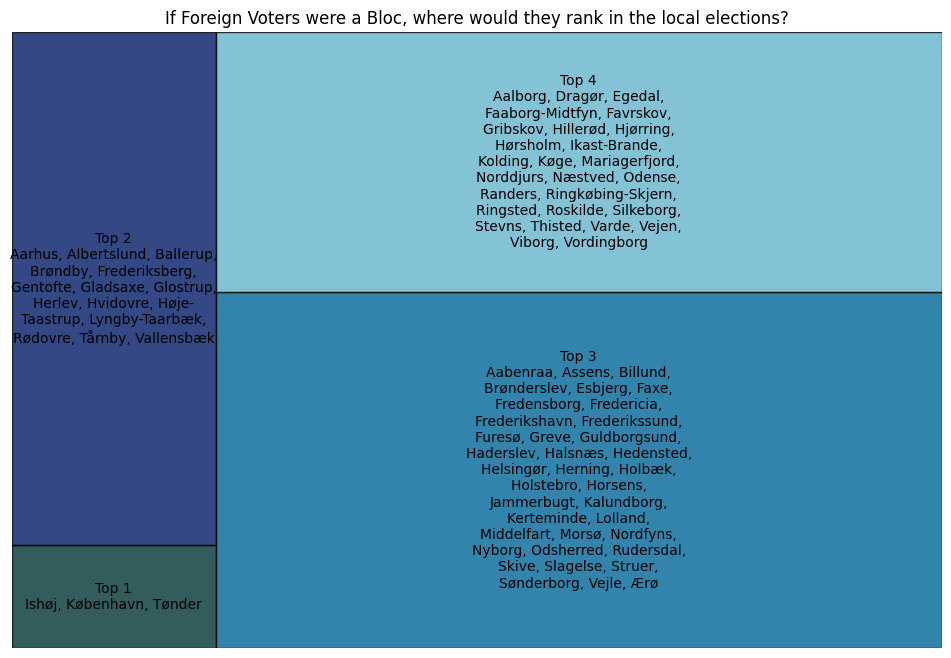

In [19]:
# Create a dictionary to store kommune names by rank
kommune_names_by_rank = {1: [],2: [], 3: [], 4: []}

# Populate the dictionary with actual kommune names
for df in kommune_dfs:
    if 'Foreign Voters' in df['Party'].values:
        rank = df[df['Party'] == 'Foreign Voters'].index[0] + 1  # Get 1-based rank
        kommune_name = df['Kommune'].iloc[0]  # Get the kommune name
        # Only store names for ranks 2 through 5
        if rank in kommune_names_by_rank:
            kommune_names_by_rank[rank].append(kommune_name)

# Sort kommune names for each rank in Danish alphabetical order
for rank, kommunes in kommune_names_by_rank.items():
    kommune_names_by_rank[rank] = sorted(kommunes, key=lambda x: x.lower())

# Prepare sizes and labels for the treemap with wrapped text
sizes = [len(kommunes) for kommunes in kommune_names_by_rank.values()]
labels = []
for rank, kommunes in kommune_names_by_rank.items():
    # Join kommune names and wrap text for each label to fit better
    kommune_text = ", ".join(kommunes)  # Combine kommune names with commas
    wrapped_text = textwrap.fill(kommune_text, width=30)  # Wrap text to 30 characters per line
    label = f"Top {rank}\n{wrapped_text}"
    labels.append(label)

# Use the magma colour scheme for the treemap to keep it nice and consistent
colors = plt.cm.ocean(np.linspace(0.2, 0.8, len(sizes)))


#  Plot the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, edgecolor="black", 
              text_kwargs={'color': 'black','fontsize': 10})  

# Title and display
plt.title("If Foreign Voters were a Bloc, where would they rank in the local elections?")
plt.axis('off')  # Hide axes for clarity
plt.show()
